In [10]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import accuracy_score

!wget https://raw.githubusercontent.com/iraouiabdou/abdou_torch/main/abdou_torch.py
import abdou_torch
from abdou_torch import Tensor, Linear, MLP, WAdam

--2025-12-01 16:58:23--  https://raw.githubusercontent.com/iraouiabdou/abdou_torch/main/abdou_torch.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6557 (6.4K) [text/plain]
Saving to: ‘abdou_torch.py’

abdou_torch.py      100%[===================>]   6.40K  --.-KB/s    in 0s      

2025-12-01 16:58:23 (85.4 MB/s) - ‘abdou_torch.py’ saved [6557/6557]



In [11]:
def one_hot_encode(labels, num_classes=10):
    return np.eye(num_classes)[labels]

print("Loading MNIST data...")
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

x_train = x_train.reshape(-1, 784).astype(np.float32) / 255.0
x_test = x_test.reshape(-1, 784).astype(np.float32) / 255.0

y_train_enc = one_hot_encode(y_train)

model = MLP(784, [64, 64, 64, 10])

optimizer = WAdam(model.parameters(), lr=0.0004, weight_decay=1e-4)

epochs = 4
batch_size = 64
steps_per_epoch = len(x_train) // batch_size
loss_history = []

Loading MNIST data...


In [12]:
print(f"Starting training on {len(x_train)} samples...")

for epoch in range(epochs):
    epoch_loss = 0

    indices = np.arange(len(x_train))
    np.random.shuffle(indices)
    x_train = x_train[indices]
    y_train_enc = y_train_enc[indices]

    for step in range(steps_per_epoch):
        start = step * batch_size
        end = start + batch_size

        batch_x = Tensor(x_train[start:end])
        batch_y = Tensor(y_train_enc[start:end], requires_grad=False)

        preds = model(batch_x)

        diff = preds - batch_y
        loss = (diff**2).sum()

        optimizer.zero_grad()
        loss.backward()

        optimizer.step()

        epoch_loss += loss.data

        if step % 100 == 0:
            print(f"Epoch {epoch+1}/{epochs} | Step {step}/{steps_per_epoch} | Loss: {loss.data:.4f}")

    print(f"Epoch {epoch+1} Complete. Avg Loss: {epoch_loss/steps_per_epoch:.4f}")
    loss_history.append(epoch_loss/steps_per_epoch)

Starting training on 60000 samples...
Epoch 1/4 | Step 0/937 | Loss: 128.1723
Epoch 1/4 | Step 100/937 | Loss: 39.2921
Epoch 1/4 | Step 200/937 | Loss: 26.4296
Epoch 1/4 | Step 300/937 | Loss: 20.8281
Epoch 1/4 | Step 400/937 | Loss: 18.0207
Epoch 1/4 | Step 500/937 | Loss: 15.7459
Epoch 1/4 | Step 600/937 | Loss: 11.2665
Epoch 1/4 | Step 700/937 | Loss: 14.3107
Epoch 1/4 | Step 800/937 | Loss: 11.9714
Epoch 1/4 | Step 900/937 | Loss: 10.5922
Epoch 1 Complete. Avg Loss: 19.3648
Epoch 2/4 | Step 0/937 | Loss: 9.6411
Epoch 2/4 | Step 100/937 | Loss: 7.9512
Epoch 2/4 | Step 200/937 | Loss: 8.0767
Epoch 2/4 | Step 300/937 | Loss: 8.2780
Epoch 2/4 | Step 400/937 | Loss: 10.3111
Epoch 2/4 | Step 500/937 | Loss: 8.3170
Epoch 2/4 | Step 600/937 | Loss: 7.7998
Epoch 2/4 | Step 700/937 | Loss: 7.7460
Epoch 2/4 | Step 800/937 | Loss: 7.5354
Epoch 2/4 | Step 900/937 | Loss: 6.2852
Epoch 2 Complete. Avg Loss: 8.1606
Epoch 3/4 | Step 0/937 | Loss: 7.6426
Epoch 3/4 | Step 100/937 | Loss: 6.1630
Epoch

In [14]:
correct = 0
total = 0

eval_batch_size = 1000
for i in range(0, len(x_test), eval_batch_size):
    x_batch = Tensor(x_test[i:i+eval_batch_size], requires_grad=False)

    logits = model(x_batch)

    predictions = np.argmax(logits.data, axis=1)
    truth = y_test[i:i+eval_batch_size]

    correct += np.sum(predictions == truth)
    total += len(truth)

acc = correct / total
print(f"Test Accuracy: {acc * 100:.2f}%")

Test Accuracy: 96.25%


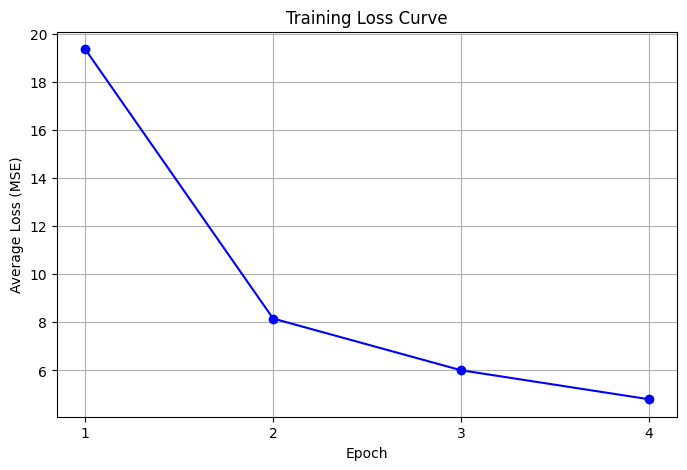


Generating prediction visualizations...


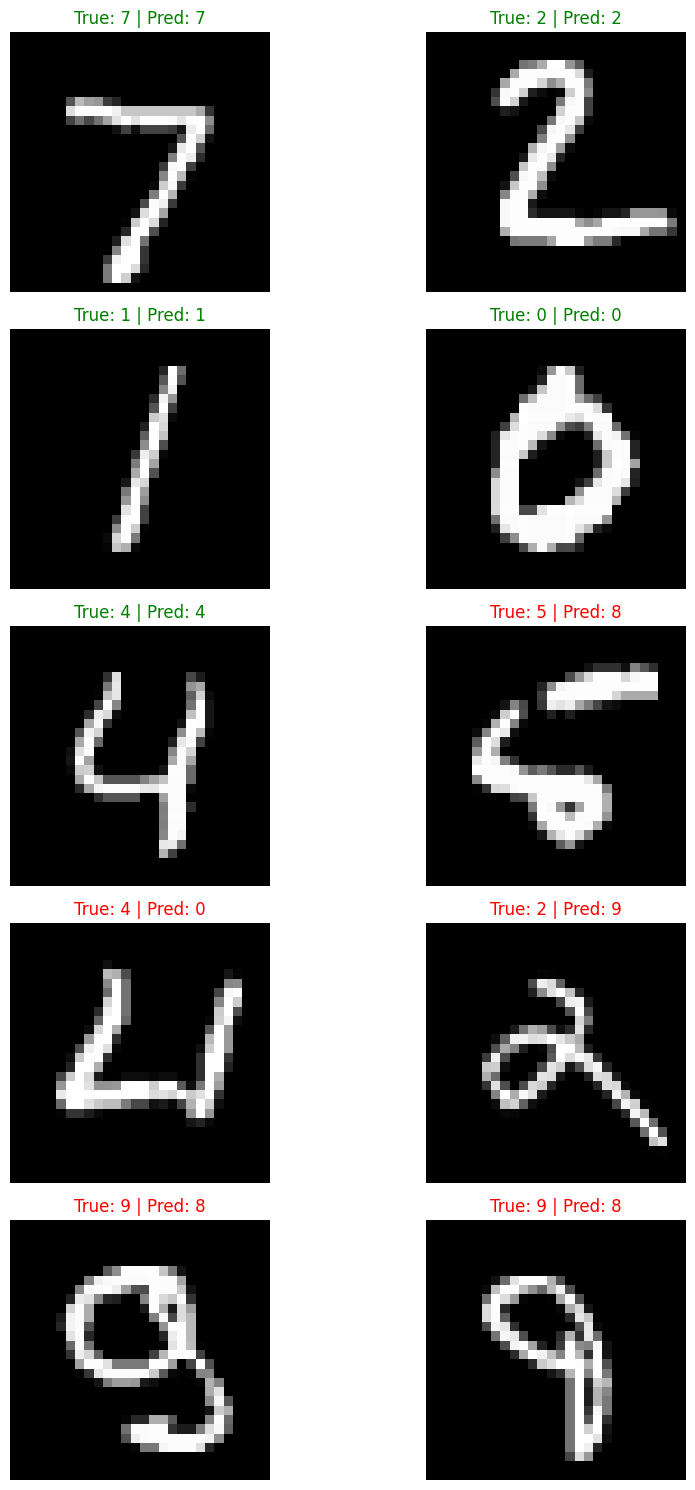

In [15]:
def plot_loss_curve(history):
  """Plots the loss history over epochs."""
  plt.figure(figsize=(8, 5))
  plt.plot(range(1, len(history) + 1), history, marker='o', linestyle='-', color='b')
  plt.title('Training Loss Curve')
  plt.xlabel('Epoch')
  plt.ylabel('Average Loss (MSE)')
  plt.grid(True)
  plt.xticks(range(1, len(history) + 1))
  plt.show()

def visualize_predictions(model, x_test, y_test, num_samples=10):
  """
  Evaluates the model on the test set and plots correct and incorrect predictions.
  """
  print("\nGenerating prediction visualizations...")

  x_sample = Tensor(x_test[:1000], requires_grad=False)
  y_true_sample = y_test[:1000]

  logits = model(x_sample)
  predictions = np.argmax(logits.data, axis=1)

  incorrect_indices = np.where(predictions != y_true_sample)[0]

  correct_indices = np.where(predictions == y_true_sample)[0]

  plot_indices = []

  if len(correct_indices) > 5:
      plot_indices.extend(correct_indices[:5])

  if len(incorrect_indices) > 5:
      plot_indices.extend(incorrect_indices[:5])

  num_plots = len(plot_indices)
  if num_plots == 0:
      print("Not enough samples to visualize.")
      return

  rows = int(np.ceil(num_plots / 2))

  plt.figure(figsize=(10, rows * 3))

  for i, idx in enumerate(plot_indices):

      image = x_test[idx].reshape(28, 28)

      plt.subplot(rows, 2, i + 1)
      plt.imshow(image, cmap='gray')

      true_label = y_true_sample[idx]
      predicted_label = predictions[idx]

      is_correct = (true_label == predicted_label)
      color = 'green' if is_correct else 'red'

      title = f"True: {true_label} | Pred: {predicted_label}"
      plt.title(title, color=color, fontsize=12)
      plt.axis('off')

  plt.tight_layout()
  plt.show()

plot_loss_curve(loss_history)
visualize_predictions(model, x_test, y_test)

I achieved more than 97.8% accuracy on the test set by adding more layers to the MLP and increasing the number of epochs